# LUNA Modelling

*Date:* 21.09.2023

*Author*: Dennis Perrett

This notebook serves the purpose of investigating and developing models for the LUNA app. The primary focus of the app is to deliver scientific individual analysis of student performance. The primary users are the lecturers, course administrators and the students themselves. The analyses can be split into two sections, namely:

#### Student Analysis 

The goal of "student analysis" is to provide an insight into latent characteristics such as ability, motivation, stress levels etc. The primary data source for this analysis are the regular surveys/questionnaire provided by us, for the students to fill out. The questionnaire consists of roughly 25 questions, aimed at extracting information such as *hours worked*, *percieved ability*, and *percieved usefulness of the course*. 

We will aim use factor analysis, perhaps expanding to SEM modelling to extract these factors.

#### Predictive Modelling

The main driver for this app is the predictive modelling, specifically modelling the drop out risk of an individual student, based on the work done by [Methods center]. The data source for this are also the regular questionnaires, supported by more general, one-off questionnaires and tests such as the Big-5 personality scale.


### Factor analysis

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [292]:
# Regular data
tx = pd.read_csv("./data/data_scales/TX/tx_long.csv")

# T0 data (One off tests)
aist  = pd.read_csv("./data/data_scales/T0/aist.csv")         # AIST/General Interest Scale
bfi   = pd.read_csv("./data/data_scales/T0/bfi.csv")          # BFI/Big-5 Personality
bg    = pd.read_csv("./data/data_scales/T0/background.csv")   # Background data
iq    = pd.read_csv("./data/data_scales/T0/iq.csv")           # IQ Test
kont  = pd.read_csv("./data/data_scales/T0/kont.csv")         # Internal and External Controll
math  = pd.read_csv("./data/data_scales/T0/math_test.csv")    # Maths ability
mot   = pd.read_csv("./data/data_scales/T0/motivation.csv")   # Motivation questionnaire
panas = pd.read_csv("./data/data_scales/T0/panas.csv")        # Positive and Negative Affect Scale

tx    = pd.read_csv("./data/data_scales/TX/tx_long.csv")      # Surveys

FileNotFoundError: [Errno 2] No such file or directory: './data/data_scales/TX/tx_long.csv'

In [ ]:
bfi.describe()

##### Weekly Questionnaires (TX)
This survey gets asked multiple times per week (determined by lecturer). Participation is not strictly necessary, so we need a model, or a method of dealing with missing data. 

The survey consists of 26 Questions. Current thinking is that we will offer different "tiers" of participation. A simplistic one, where the survey is kept short, a "full"-tier, where the survey questions are asked in full, and a level in between. The models will be adjusted accordingly. 

The columns/variables are (**Column/variable name**: Explanation (*"The prompt in the questionnaire"*)):
- **studentID**: The *university* student ID (Immatrikulationnummer in DE). Not necessarily unique, however will be unique within a given module/uni.
- **meas**: The ID of the given survey.
- **Iv1_state**: Intrinsic value (*"I enjoyed the content"*)
- **Av1_state**: Attainment value (*"It is important to me to know a lot about the content"*)
- **Uv1_state**: Utility value (*"The content will be useful to me later on in my career"*)
- **Co1_state**: Cost (*"To understand this content, a lot of time needs to be sacrificed"*)
- **Co2_state**: Cost (*"Engaging with this content exhausts me"*)
- **Angst_abbruch_state**: Fear of dropping out (*"I am currently thinking about dropping out [degree]"*)
- **Angst_scheitern_state**: Fear of failing (*"I am scared I wont be able to complete the degree"*)
- **Leist_verstehen_state**: Understanding of the content (*"I understand the content we are currently covering "*)
- **Leist_bearbeiten_state**: Task understanding (*"I can complete the tasks of the current assignments"*)
- **Leist_stess_state**: Stress level (*"I am currently feeling stressed by the [degree]"*)
- **Leist_ueberfordert_state**: Overwhelmed (*"I am feeling overwhelmed by the requirements of the [degree]"*)
- **Wiss_kommilitonen_state**: Percieved ability of classmates (*"This is how I estimate my [topic] ability compared to my classmates"*)
- **Wiss_mathe_state**: Percieved [topic] ability (*"This is how I estimate my [topic] ability"*)
- **PANP01_state**: Feeling Engaged (*"Please select how well 'Engaged' describes your current emotional state"*)
- **PANP05_state**: Feeling Active (*"Please select how well 'active' describes your current emotional state"*)
- **PANP08_state**: Feeling Stimulated (*"Please select how well 'stimulated' describes your current emotional state"*)
- **PANN01_state**: Feeling Nervous (*"Please select how well 'nervous' describes your current emotional state"*)
- **PANN05_state**: Feeling Anxious (*"Please select how well 'anxious' describes your current emotional state"*)
- **PANN09_state**: Feeling troubled (*"Please select how well 'troubled' describes your current emotional state"*)
- **Block2_lerngruppe_state**: Working with a study group (*"I worked a lot with a study group"*)
- **Block2_abschreiben_state**: Understanding of tasks (*"The majority of submitted tasks, I understood completely"*)
- **Block2_durchhaltevermoegen**: Persistence (*"I give up quickly, when it comes to difficult tasks"*)
- **Block2_vorNachbereitung_state**: Preparation/revision (*"I spend a lot of time preparing for/revising the lectures"*)
- **Block2_zeitaufwant_state**: Time commitment (*"How long did you spend working on the content outside of class time?"*)
- **Block2_anwesenheit_state**: Going to class (*"How often did you attend lectures"*)
- **Block2_gruppe_state**: Study Group participation (*"Did you work with a study group?"*)

#### Raw Data

In [293]:
tx.head(5)

,studentID,meas,Iv1_state,Av1_state,Uv1_state,Co1_state,Co2_state,Angst_abbruch_state,Angst_scheitern_state,Leist_verstehen_state,...,PANN09_state,Block2_lerngruppe_state,Block2_abschreiben_state,Block2_durchhaltevermoegen_state,Block2_vorNachbereitung_state,Block2_zeitaufwand_state,Block2_anwesenheit_state,Block2_gruppe_state,Summe,event
0,student1,8,3.0,3.0,4.0,4.0,4.0,2.0,4.0,3.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,student1,10,3.0,3.0,2.0,2.0,3.0,1.0,2.0,4.0,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,student1,12,3.0,2.0,3.0,2.0,2.0,1.0,2.0,4.0,...,4.0,4.0,4.0,2.0,3.0,8.0,3.0,1.0,89.0,0
3,student1,15,4.0,3.0,3.0,2.0,2.0,4.0,4.0,3.0,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,student1,17,3.0,2.0,3.0,3.0,4.0,1.0,2.0,3.0,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


#### Data Summary

In [294]:
tx.describe().T

,count,mean,std,min,25%,50%,75%,max
meas,3187.0,60.146847,36.523721,8.0,29.0,54.0,96.0,131.0
Iv1_state,2364.0,2.660321,0.794138,1.0,2.0,3.0,3.0,4.0
Av1_state,2365.0,2.764482,0.908648,1.0,2.0,3.0,3.0,4.0
Uv1_state,2359.0,2.257736,0.903132,1.0,2.0,2.0,3.0,4.0
Co1_state,2360.0,2.965678,0.913425,1.0,2.0,3.0,4.0,4.0
Co2_state,2362.0,2.735394,0.949737,1.0,2.0,3.0,3.0,4.0
Angst_abbruch_state,2378.0,1.573171,0.866273,1.0,1.0,1.0,2.0,4.0
Angst_scheitern_state,2380.0,2.578571,1.062231,1.0,2.0,3.0,3.0,4.0
Leist_verstehen_state,2362.0,2.602032,0.789037,1.0,2.0,3.0,3.0,4.0
Leist_bearbeiten_state,2351.0,2.576350,0.796280,1.0,2.0,3.0,3.0,4.0


#### Eigenvalue decomposition

We start by investigating the eigenvalues of the survey, to get an idea of how many principal components we have. 

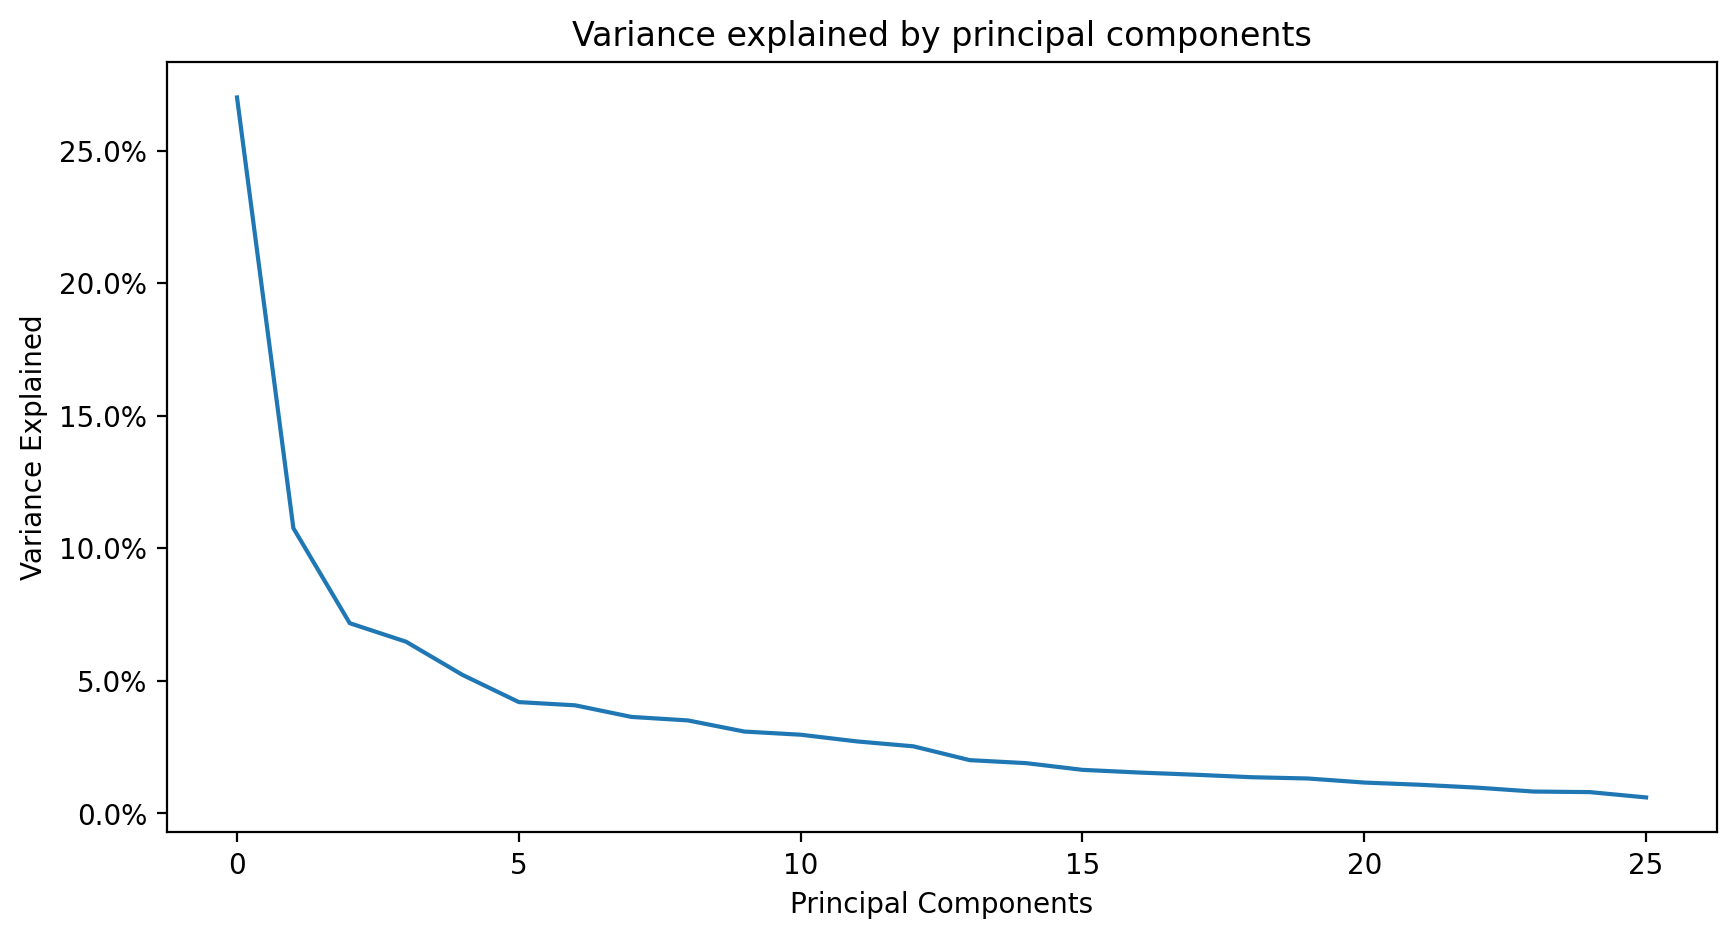

In [295]:
def normalise(a):
    """ Normalises an input matrix along the first dimension """
    a = (a - a.mean(axis=0))/a.std(axis=0)
    return a

# Step 1: Prepare the data for analysis. We can be lazy here and just throw out any observation with missing data. 
# At this point we are simply doing very simplistic exploratory analysis.
tx_data = tx.dropna()
tx_data = tx_data.iloc[:,2:-2].to_numpy() # Extract relevant data (question answers)

# Step 2: Normalise the data
tx_data = normalise(tx_data) 

# Step 3: Calculate the covariance matrix. 
tx_cov = np.cov(tx_data.T)

# Step 4: Calculate the eigenvalues / vectors
eigenvalues, eigenvectors = np.linalg.eig(tx_cov)


# Step 5: Sort the eigenvalues in order of largest to smallest.
# np.argsort can only provide lowest to highest; use [::-1] to reverse the list
order_of_importance = np.argsort(eigenvalues)[::-1] 

# utilize the sort order to sort eigenvalues and eigenvectors
sorted_eigenvalues = eigenvalues[order_of_importance]
sorted_eigenvectors = eigenvectors[:,order_of_importance] # sort the columns

# Step 5: Get the portion of explained variance.
# use sorted_eigenvalues to ensure the explained variances correspond to the eigenvectors
explained_variance = sorted_eigenvalues / np.sum(sorted_eigenvalues)

# Plot the explained variance.
def plot_explained_variance(explained_variance):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(explained_variance)
    plt.title("Variance explained by principal components")
    plt.ylabel("Variance Explained")
    plt.xlabel("Principal Components")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plot_explained_variance(explained_variance)

In this section, we aimed to get a feel for the dimensionality of the data. 

A reasonable number of principal components would be about 5. This does not however rule out specific latent variables. 

Lets have a look at how many meaningful factors we can extract "naturally":

In [296]:
import factor_analyzer

ModuleNotFoundError: No module named 'factor_analyzer'

In [297]:
# Instantiate factor analysis object
from factor_analyzer.factor_analyzer import FactorAnalyzer 
fa = FactorAnalyzer(rotation='varimax', n_factors=10)
fa.fit(tx_data)
# Check Eigenvalues
ev, v = fa.get_eigenvalues()
plot_explained_variance(ev/ev.sum()) # Small differences from above, but nothing of any relevance.

ModuleNotFoundError: No module named 'factor_analyzer'

In [298]:
loadings = pd.DataFrame(fa.loadings_, index=tx.iloc[:,2:-2].columns)
loadings

NameError: name 'fa' is not defined

TypeError: Invalid shape (3,) for image data

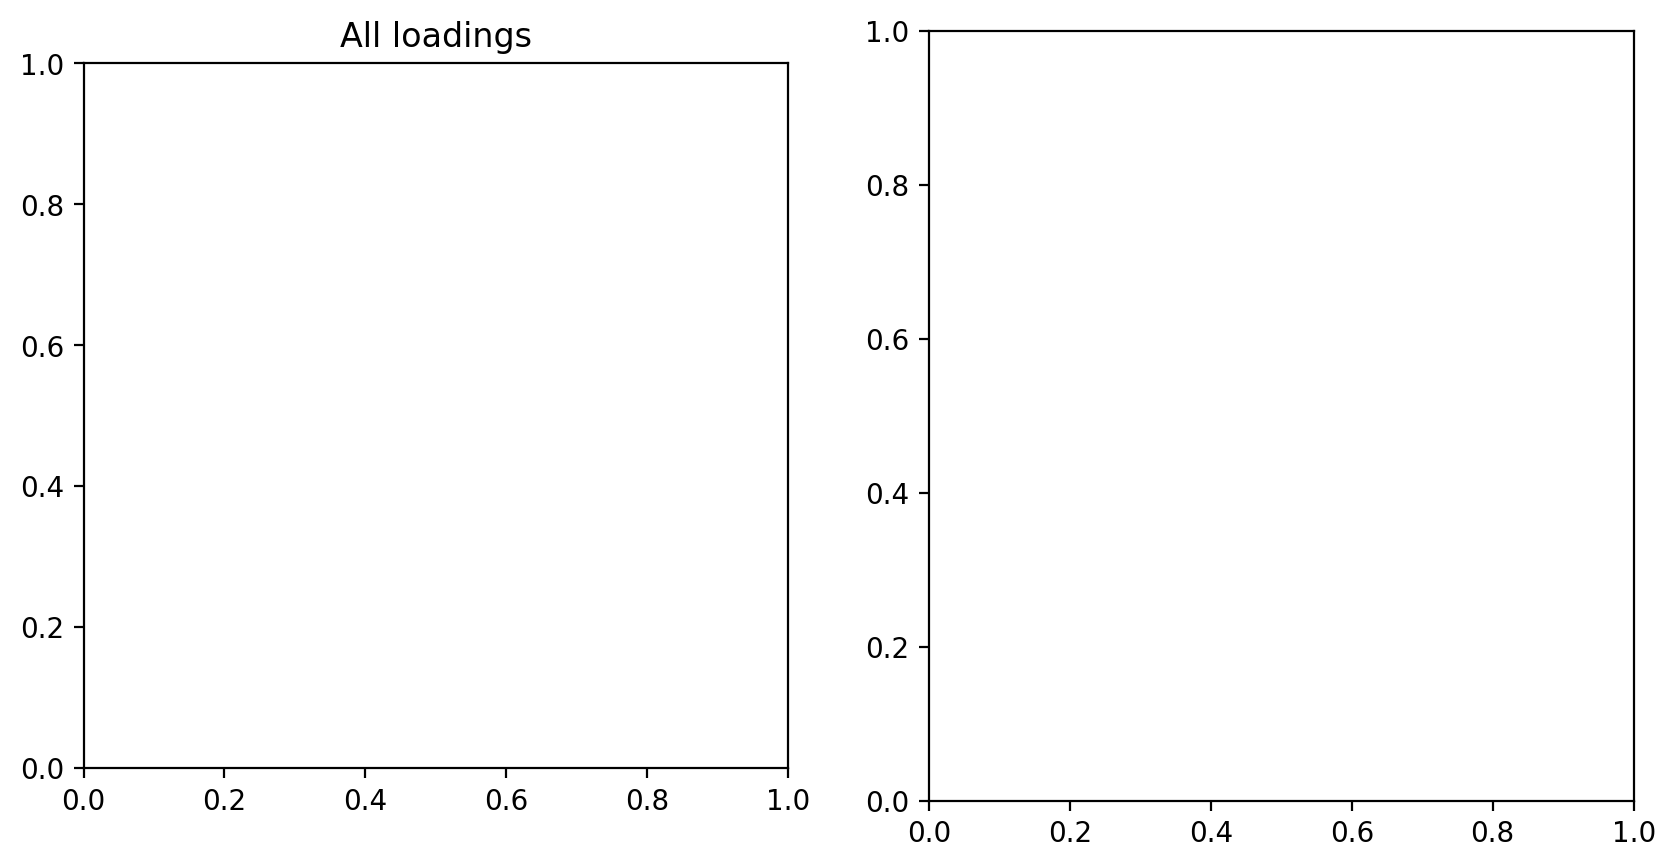

In [299]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_title("All loadings")
pos = ax[0].imshow(loadings, cmap='RdBu', interpolation='none');
ax[0].set_yticks(np.arange(0,26,1))
ax[0].set_yticklabels(tx.iloc[:,2:-2].columns);
fig.colorbar(pos)

cutoff=0.5
lm = np.ma.masked_array(loadings, mask=np.abs(loadings)<=cutoff)
ax[1].set_title(f"Loadings > |{cutoff}|")
pos = ax[1].imshow(lm, cmap='RdBu', interpolation='none')
ax[1].set_yticks(np.arange(0,26,1))
ax[1].set_yticklabels(tx.iloc[:,2:-2].columns);
fig.colorbar(pos)

The results here are quite promising. The plot on the left gives us an overview of how every observed variable is loading on its latent factor. The plot on the right shows the same information, but limited loadings of a significant (arbitrary) size. 

Let us interpret each factor 1 by 1:

Factor 1:
- **Co1_state**: Cost (*"To understand this content, a lot of time needs to be sacrificed"*)
- **Co2_state**: Cost (*"Engaging with this content exhausts me"*)
- **Leist_stess_state**: Stress level (*"I am currently feeling stressed by the [degree]"*)
- **Leist_ueberfordert_state**: Overwhelmed (*"I am feeling overwhelmed by the requirements of the [degree]"*)
  
Interestingly, the overwhelmed variable is negatively correlated with the stress variable. Perhaps this question has been negatively coded? The covariances are positive though, suggesting they are correctly coded. Perhaps this is because we are subtracting the "overwhelmed" portion of the factor and using it somewhere else (see factor 3). Considering this, this factor can probabily be interpretted as **difficulty**.

Factor 2:
- **PANN01_state**: Feeling Nervous (*"Please select how well 'nervous' describes your current emotional state"*)
- **PANN05_state**: Feeling Anxious (*"Please select how well 'anxious' describes your current emotional state"*)
- **PANN09_state**: Feeling troubled (*"Please select how well 'troubled' describes your current emotional state"*)
  
As above, this factor can also be interpretted. Likely something related to **stress**.


Factor 3:
- **PANP01_state**: Feeling Engaged (*"Please select how well 'Engaged' describes your current emotional state"*)
- **PANP05_state**: Feeling Active (*"Please select how well 'active' describes your current emotional state"*)
- **PANP08_state**: Feeling Stimulated (*"Please select how well 'stimulated' describes your current emotional state"*)
  
We can interpret this factor as something along the lines of **interest**, or **motivation**. I am sure there is already an official interpretation for this factor (hinted at by the "PANP" name)

Factor 4:
- **Wiss_kommilitonen_state**: Percieved ability of classmates (*"This is how I estimate my [topic] ability compared to my classmates"*)
- **Wiss_mathe_state**: Percieved [topic] ability (*"This is how I estimate my [topic] ability"*)
  
Can probabily be interpretted as **confidence**.

Factor 5:
- **Iv1_state**: Intrinsic value (*"I enjoyed the content"*)
- **Leist_verstehen_state**: Understanding of the content (*"I understand the content we are currently covering "*)

A slightly more difficult factor to interpret. A combination of enjoyment and understanding. Both of these variables are (not totally negligably) negatatively loaded on Factor 1 (difficulty), suggesting this may be in some form an **enjoyment** or **easiness** factor.

Factor 6: 
- **Uv1_state**: Utility value (*"The content will be useful to me later on in my career"*)

No real factor here - simply its own question. 

Factor 7: 
- **Block2_abschreiben_state**: Understanding of tasks (*"The majority of submitted tasks, I understood completely"*)

At this point, we are getting away from latent variables. The first 4 are definitely of use to us. Maybe we can see what happens if we reduce our number of latent variables to 4 rather than 10...

In [300]:
fa4 = FactorAnalyzer(rotation='varimax', n_factors=4)
fa4.fit(tx_data)
loadings4 = fa4.loadings_

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].set_title("All loadings")
pos = ax[0].imshow(loadings4, cmap='RdBu', interpolation='none');
ax[0].set_yticks(np.arange(0,26,1))
ax[0].set_yticklabels(tx.iloc[:,2:-2].columns);
fig.colorbar(pos)

cutoff=0.5
l4m = np.ma.masked_array(loadings4, mask=np.abs(loadings4)<cutoff)
ax[1].set_title(f"Loadings > |{cutoff}|")
pos = ax[1].imshow(l4m, cmap='RdBu', interpolation='none');
ax[1].set_yticks(np.arange(0,26,1))
ax[1].set_yticklabels(tx.iloc[:,2:-2].columns);
fig.colorbar(pos);

NameError: name 'FactorAnalyzer' is not defined

The results here also look very promising. We still have our 4 main factors - i.e. they appear to be combinations of roughly the same variables.

Factor 1:
- **Co1_state**: Cost (*"To understand this content, a lot of time needs to be sacrificed"*)
- **Co2_state**: Cost (*"Engaging with this content exhausts me"*)
- **Leist_stess_state**: Stress level (*"I am currently feeling stressed by the [degree]"*)
- **Leist_ueberfordert_state**: Overwhelmed (*"I am feeling overwhelmed by the requirements of the [degree]"*)

This creates a most definite general **difficulty** variable.

Factor 2:
- **PANN01_state**: Feeling Nervous (*"Please select how well 'nervous' describes your current emotional state"*)
- **PANN05_state**: Feeling Anxious (*"Please select how well 'anxious' describes your current emotional state"*)
- **PANN09_state**: Feeling Troubled (*"Please select how well 'troubled' describes your current emotional state"*)

This is still kept separate from factor 1, suggesting they are measuring 2 different aspects. Using myself as an example, factor 1 would measure the amount of effort I am putting in, while this factor (2) would measure my **emotional regulation**. 

Factor 3:
- **Leist_verstehen_state**: Understanding of the content (*"I understand the content we are currently covering "*)
- **Leist_bearbeiten_state**: Task understanding (*"I can complete the tasks of the current assignments"*)
- **Iv1_state**: Intrinsic value (*"I enjoyed the content"*)
- **Av1_state**: Attainment value (*"It is important to me to know a lot about the content"*)

I understand the "vibe" of the factor, but just dont know what to call it...

Factor 4:
- **PANP01_state**: Feeling Engaged (*"Please select how well 'Engaged' describes your current emotional state"*)
- **PANP05_state**: Feeling Active (*"Please select how well 'active' describes your current emotional state"*)
- **PANP08_state**: Feeling Stimulated (*"Please select how well 'stimulated' describes your current emotional state"*)

**Interest** or so. See above.





So far, we aimed to implement a **difficulty**, **interest**, and **satistifaction** variables. 

Luckily, our intuition was correct in that we can just use these factors outlined above. We can do this in the short run, and not have to worry about overly complicated models / SEMs yet.

### Predictive modelling

Now for the main driver of the LUNA app... modelling drop out risk.

Lets start with a basic linear regression to see what we can get out of it. This will consider no time dependencies, or hierarchies etc yet

In [301]:
import statsmodels.formula.api as sm

In [302]:
tx.columns

Index(['studentID', 'meas', 'Iv1_state', 'Av1_state', 'Uv1_state', 'Co1_state',
       'Co2_state', 'Angst_abbruch_state', 'Angst_scheitern_state',
       'Leist_verstehen_state', 'Leist_bearbeiten_state', 'Leist_stress_state',
       'Leist_ueberfordert_state', 'Wiss_kommilitonen_state',
       'Wiss_mathe_state', 'PANP01_state', 'PANP05_state', 'PANP08_state',
       'PANN01_state', 'PANN05_state', 'PANN09_state',
       'Block2_lerngruppe_state', 'Block2_abschreiben_state',
       'Block2_durchhaltevermoegen_state', 'Block2_vorNachbereitung_state',
       'Block2_zeitaufwand_state', 'Block2_anwesenheit_state',
       'Block2_gruppe_state', 'Summe', 'event'],
      dtype='object')

In [303]:
mod = """
    event
    ~ PANP01_state
    + PANP05_state
    + PANP08_state
    + PANP01_state
    + PANN05_state
    + PANN09_state
"""

model = smf.logit(mod, data=tx)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.048193
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  event   No. Observations:                 2365
Model:                          Logit   Df Residuals:                     2359
Method:                           MLE   Df Model:                            5
Date:                Wed, 07 Feb 2024   Pseudo R-squ.:                  0.1195
Time:                        17:23:34   Log-Likelihood:                -113.98
converged:                       True   LL-Null:                       -129.45
Covariance Type:            nonrobust   LLR p-value:                 9.614e-06
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5682      0.866     -2.966      0.003      -4.266      -0.871
PANP01_state    -1.2462      0.283     -4.398      0.000      -1.802      -0.691
PANP05_state     0.0564      0.280      0.201      0.841      -0.493       0.605
PANP08_state     0.3993      0.271      1.472      0.141      -0.132       0.931
PANN05_state     0.4952      0.245      2.022      0.043       0.015       0.975
PANN09_state    -0.3307      0.236     -1.400      0.161      -0.794       0.132
================================================================================
"""

This model is absoutely useless. I don't think we could pump out all that much performance. We need a different approach entirely. The good news is that the variables are useful, despite the prediction being shit.

It would pay to have a look had some Hidden Markov Models or other sequence models or RNNs

In [304]:
from pymer4.models import Lmer

model = Lmer("event  ~ meas  + (1 + meas|studentID)",
             data=tx, family = 'binomial')

print(model.fit(control="optimizer='Nelder_Mead', optCtrl = list(FtolAbs=1e-8, XtolRel=1e-8)"))

ModuleNotFoundError: No module named 'pymer4'

In [305]:
preds = model.predict(tx,verify_predictions=False)

TypeError: predict() got an unexpected keyword argument 'verify_predictions'

In [306]:
preds = np.array(list(preds)).round()  # to numpy

NameError: name 'preds' is not defined

In [307]:
tx.event

0       0
1       0
2       0
3       0
4       0
       ..
3182    0
3183    0
3184    0
3185    0
3186    1
Name: event, Length: 3187, dtype: int64

In [308]:
import numpy as np

from matplotlib import pyplot as plt
from numpy.typing import ArrayLike

import scipy.io as sio
import scipy.linalg as sla
import scipy.special as ssp


In [309]:
confusion_matrix(preds,tx.event) # Perfect fit - model works. (technically speaking)

NameError: name 'confusion_matrix' is not defined

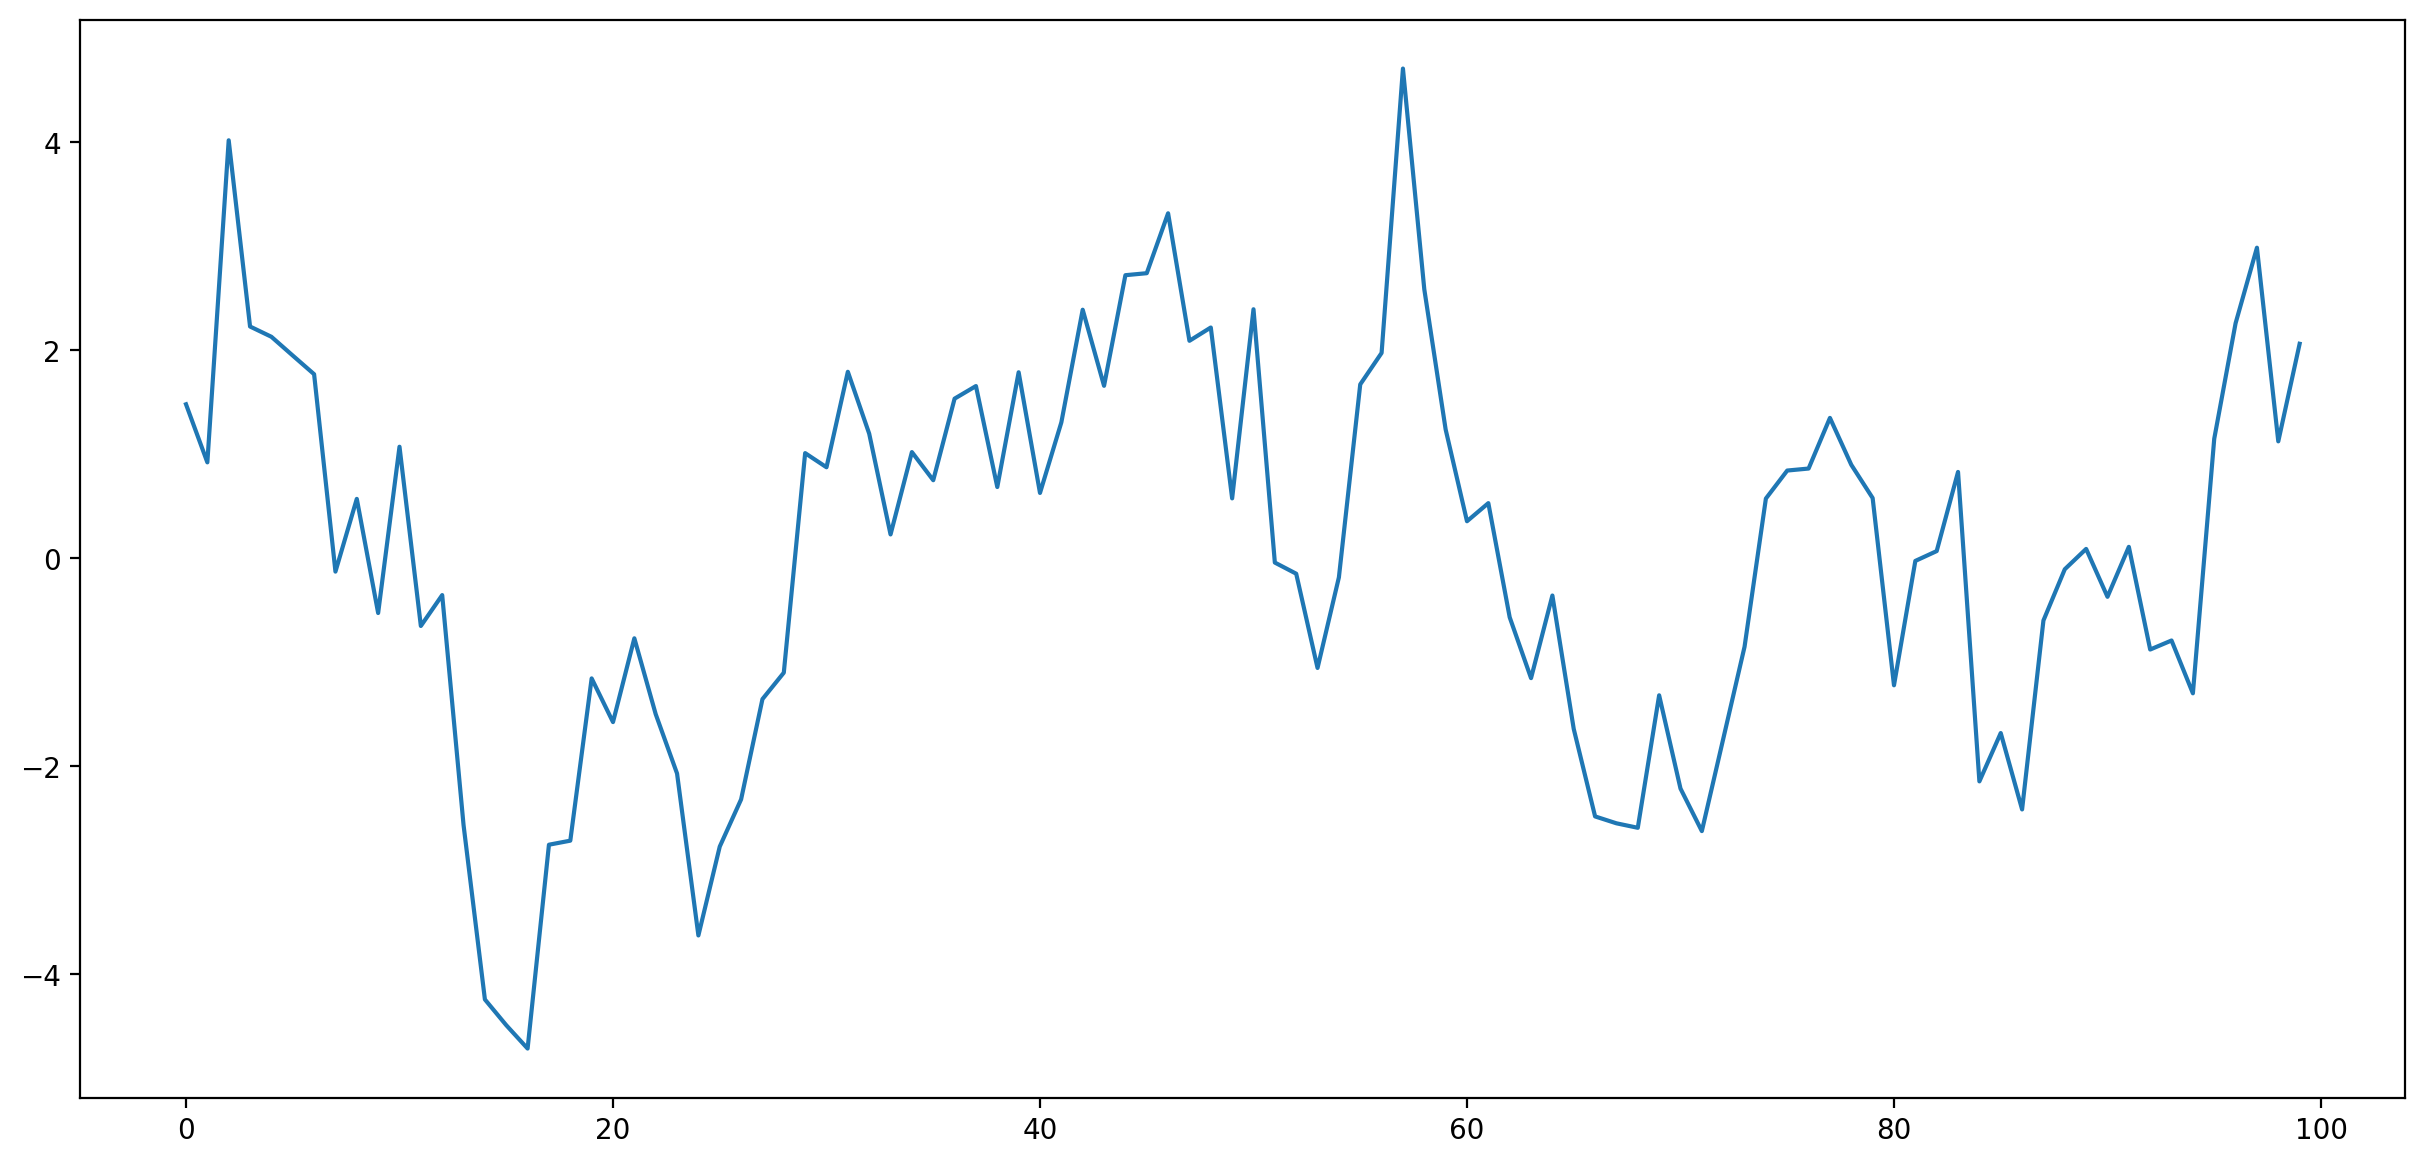

In [315]:
def simulate_ar3(n_samples, phi):
    """
    Simulate AR(3) data.

    Parameters:
    - n_samples: int, number of samples to generate
    - phi: array-like, AR parameters [phi1, phi2, phi3]

    Returns:
    - simulated_data: array-like, simulated data
    """
    p = len(phi)
    simulated_data = np.zeros(n_samples + p)  # Leave room for initial values
    # Initialize with random noise
    simulated_data[:p] = np.random.randn(p)
    # Generate data based on AR(3) process
    for t in range(p, n_samples + p):
        simulated_data[t] = np.dot(phi, simulated_data[t - p:t][::-1]) + np.random.randn()
    return simulated_data[p:]

# Parameters
n_samples = 100  # Number of samples to generate
phi = np.array([0.8, 0.1, 0])  # AR parameters

# Simulate AR(3) data
simulated_data = simulate_ar3(n_samples, phi)

plt.plot( simulated_data);

In [372]:
import numpy as np

class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = self.F @ self.x + np.dot(self.B, u)
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        y = z - self.H @ self.x
        S = self.R + self.H @ self.P @ self.H.T # update state
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        I = np.eye(self.n)
        self.P = (I - K @ self.H) @ self.P @ (I - K @ self.H).T + (K @self.R @ K.T)


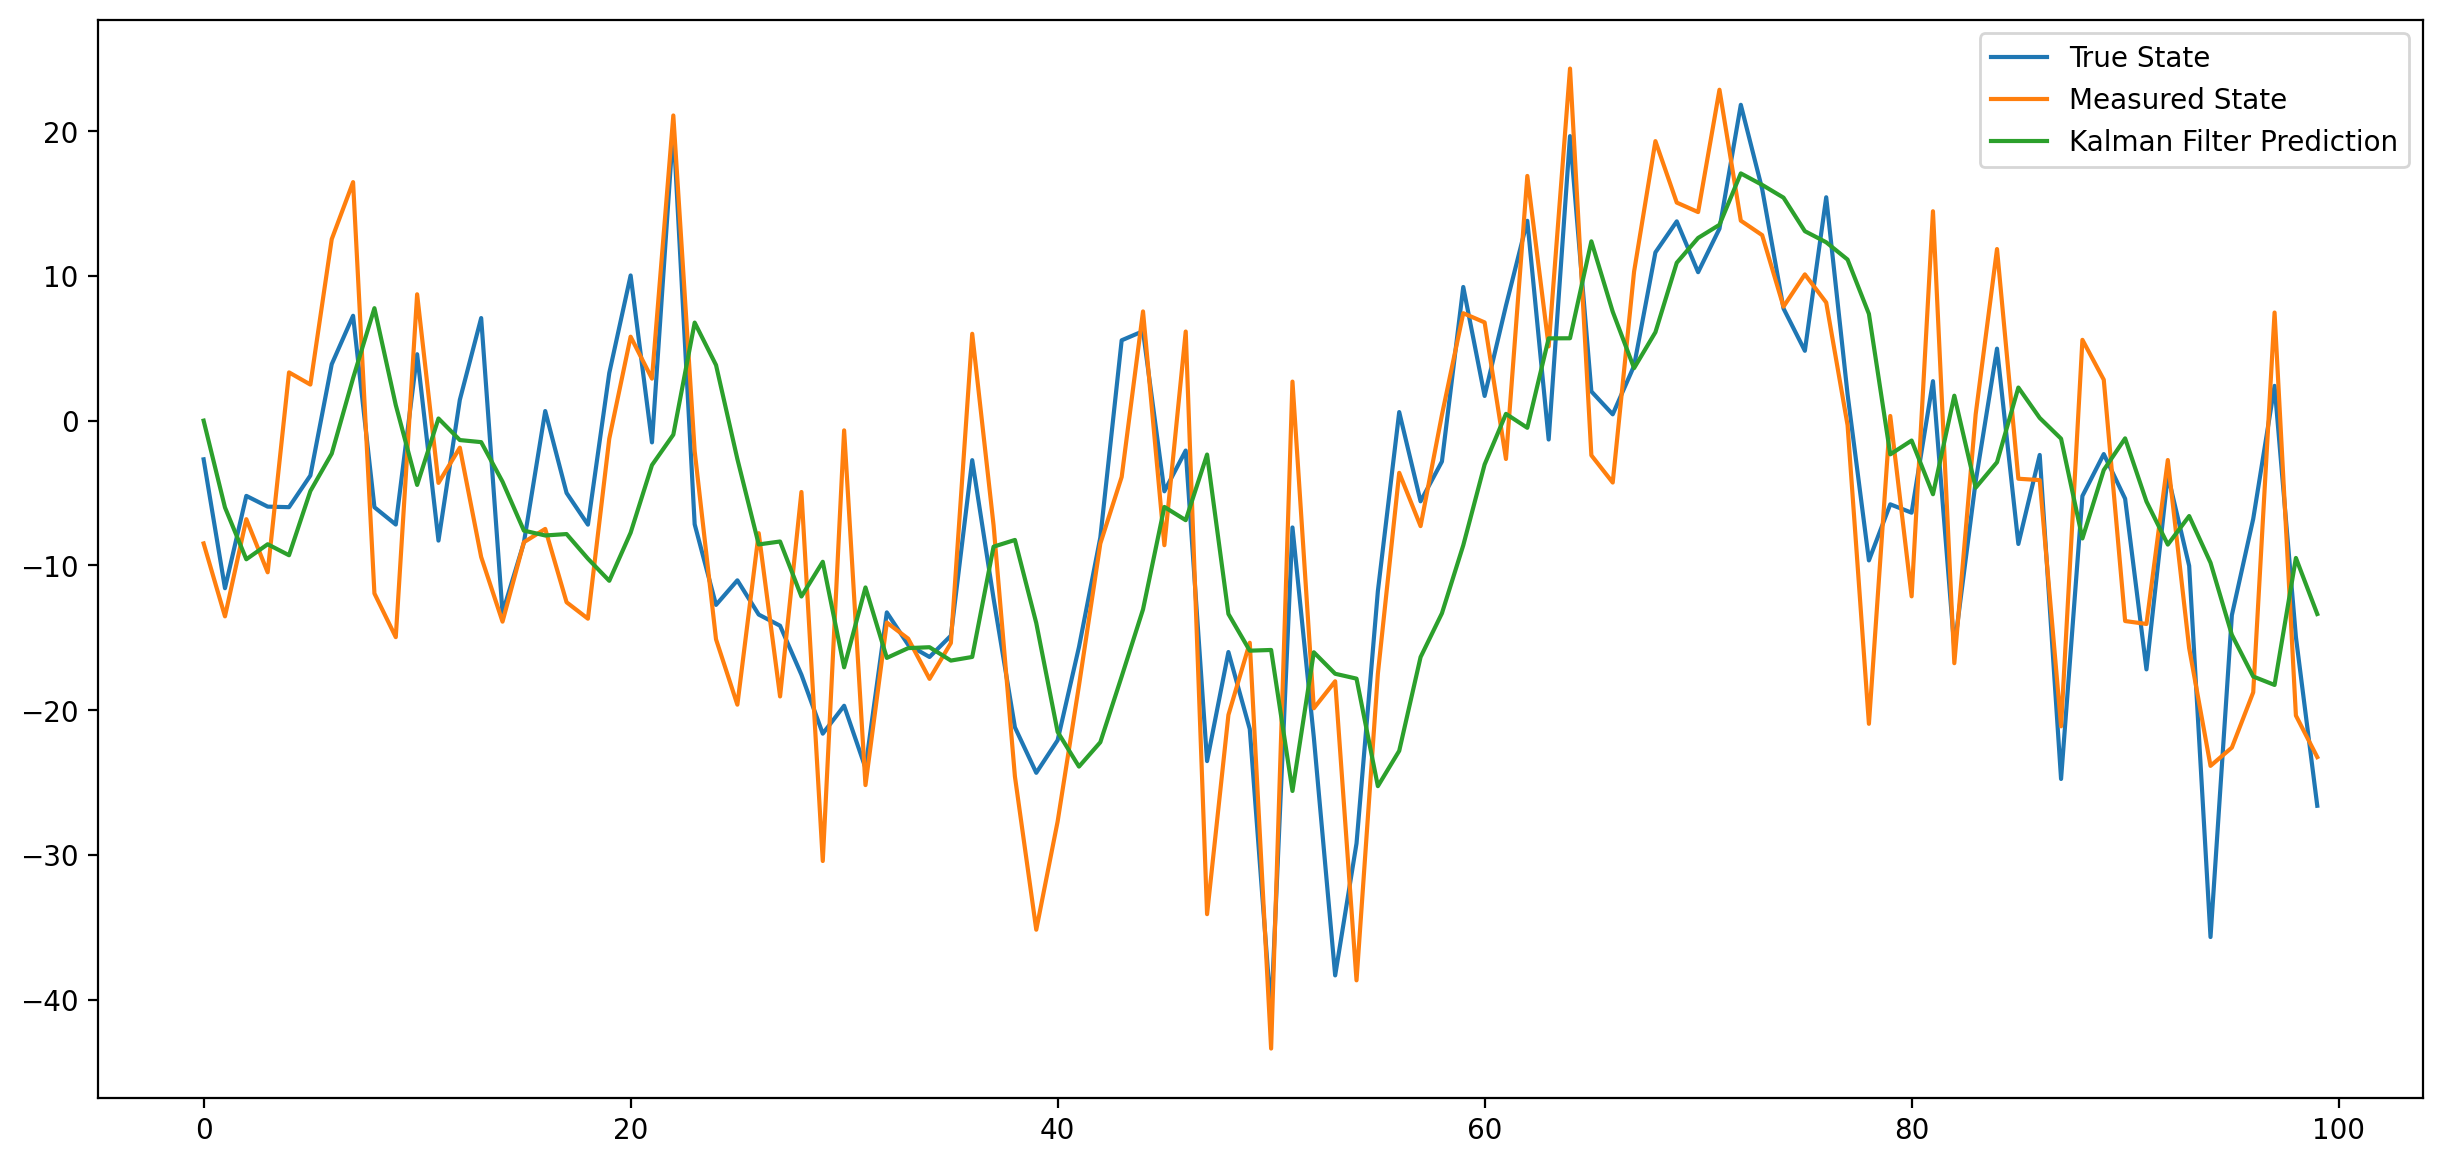

In [417]:
dt = 1.0/60
F = np.array([
    [1, dt, 0],
    [0, 1, dt],
    [0, 0, 1]
])
H = np.array([1, .3, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = np.linspace(-10, 10, 100)

true_state = simulate_ar3(100, [0.5,0.3,0.1]).reshape(-1,1)*10
observations = true_state @ H + np.random.multivariate_normal([0,0,0],[[50,0,0],[0,50,0],[0,0,105]],100)
observed_state = observations @ H.T
kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in observed_state:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

import matplotlib.pyplot as plt
plt.plot(range(len(true_state)), true_state, label = 'True State')
plt.plot(range(len(observed_state)), observed_state, label = 'Measured State')
plt.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction')
plt.legend()
plt.show()


In [406]:
observations @ H.T

array([[ -64.15081045],
       [  -3.2244639 ],
       [-141.9561226 ],
       [ -32.90741811],
       [ -17.96173978],
       [ -84.24573225],
       [ -46.4170104 ],
       [-101.51215677],
       [ -48.0310338 ],
       [ -14.19630293],
       [ -86.43332563],
       [-125.070276  ],
       [ -28.89231467],
       [  46.12829555],
       [  27.202449  ],
       [  56.05315718],
       [  23.51288867],
       [  40.85177641],
       [  50.80087831],
       [  29.80828893],
       [ 109.41962416],
       [  77.23691723],
       [  90.62044555],
       [  69.41428627],
       [  68.75310583],
       [ 130.50694108],
       [  98.14331042],
       [ 103.9593196 ],
       [ 105.21624892],
       [  76.24467912],
       [   2.82234031],
       [ 121.33601112],
       [ 126.43232234],
       [ 167.25118501],
       [  75.28988248],
       [ 178.73437145],
       [ 235.82717301],
       [ 238.75496703],
       [ 296.51926547],
       [ 287.80735975],
       [ 210.08723557],
       [ 247.247